In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import time
from torch import nn
from skimage.io import imshow
%matplotlib inline
from torch.nn import functional as F
import torch.utils.data
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

In [2]:
dimZ = 100

# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        #encoder
        self.encoder = nn.Sequential(
            nn.Linear(6075, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 2*dimZ))
        
        #decoder
        self.decoder = nn.Sequential(
            nn.Linear(dimZ, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 6075 * 2)
        )
        self.s = nn.Sigmoid()
    def gaussian_sampler(self, mu, logsigma):
        #print(mu.size(), logsigma.size())
        if self.training:
            std = logsigma.exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def encode(self, x):
        combined = self.encoder(x)
        return combined[:, :dimZ], combined[:, dimZ:]
        
    def decode(self, x):
        combined = self.decoder(x)
        return self.s(combined[:, :6075]), combined[:, 6075:]
        
    def forward(self, x):
        latent_mu, latent_logsigma = self.encode(x)
        samples = self.gaussian_sampler(latent_mu, latent_logsigma)
        reconstruction_mu, reconstruction_logsigma = self.decode(samples)
        return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma


In [3]:
net_VAE = VAE().to('cpu')
net_VAE.load_state_dict(torch.load('VAE-deepfunneled/weights-vae-deepfunneled', map_location='cpu'))
net_VAE.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=6075, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=200, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=12150, bias=True)
  )
  (s): Sigmoid()
)

In [5]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

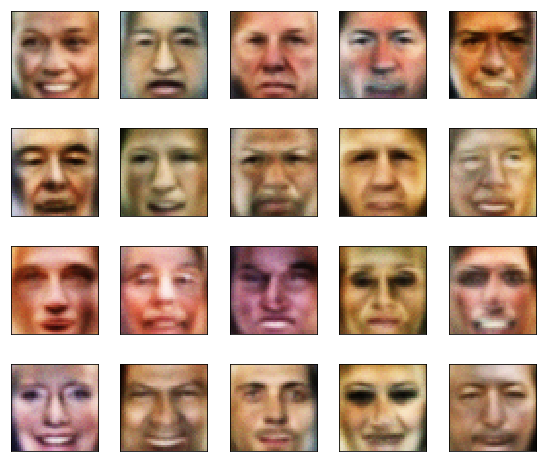

In [8]:
vae=net_VAE
samples = torch.randn(20, dimZ, requires_grad=True)
decoder_mu = vae.decode(samples)[0]
image_h = 45
image_w = 45
plot_gallery(decoder_mu.data.cpu().numpy(), image_h, image_w, n_row=4, n_col=5)